In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Import Libraries

In [10]:
import os

In [1]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pickle5
import math
import matplotlib.pyplot as plt

## Load pickle file

In [2]:
dir_name = './processed/'

def load_pickle(filename):
    with open(dir_name + filename + '.pkl', 'rb') as f:
        return pickle5.load(f)

## Initialisation - based on paper

In [3]:
img_size = 227
num_channels = 3
batch_size = 50
width, height = 256, 256
cropped_width, cropped_height = 227, 227
num_classes = 1

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Learning rate
lr = 1e-3

From the paper, it said to drop the learning rate to 1e^-4 when epochs reach 10k.
(1e^-3 - 1e^-4) is a drop of 10%, hence we use 0.1

In [4]:
def step_decay(epoch):
    init_lrate = 1e-3
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

weight_init = keras.initializers.TruncatedNormal(mean=0.0,stddev=0.01,seed=seed)
#bias_init = tf.keras.initializers.Constant(value=0.1)
sgd = keras.optimizers.SGD(learning_rate=lr,momentum=0.0)
loss_func = keras.losses.BinaryCrossentropy()
lrate = keras.callbacks.LearningRateScheduler(step_decay)

## Load and process data

In [5]:
to_pickle = [['train', 'test']]
for i in range(5):
  to_pickle.append(["fold_%s_train_sub"%i, "fold_%s_val"%i])

In [6]:
one_csv = to_pickle[0] # change
train_pickle = load_pickle(one_csv[0])
val_pickle = load_pickle(one_csv[1])

X_train = np.array(train_pickle['images'])    
y_train = np.array(train_pickle['genders'])

X_val = np.array(val_pickle['images'])
y_val = np.array(val_pickle['genders'])

Check that the image size is as described in the paper (256x256)

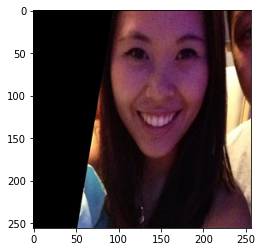

In [7]:
img = X_train[50,:,:,:]
plt.imshow(img)

Crop image and check that image is now cropped as described in paper (227x227)

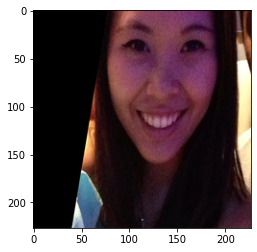

In [8]:
left = int((width - cropped_width)/2)
right = int((width + cropped_width)/2)
top = int((height - cropped_height)/2)
bottom = int((height + cropped_height)/2)

X_train = X_train[:,left:right,top:bottom,:]
X_val = X_val[:,left:right,top:bottom,:]

img = X_train[50,:,:,:]
plt.imshow(img)

## Model - based on paper

In [11]:
model = keras.models.Sequential()
# First convolution layer - 96 filters, 7x7 kernel, 4 strides, valid padding, relu
model.add(keras.layers.Conv2D(96, (7,7),input_shape = (cropped_width, cropped_height, num_channels), strides = 4,
                                  padding ='valid',activation = 'relu',kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))
# Output - 96x28x28
model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))

# Second convolution layer - 256 filters, 5x5 kernel, relu, same padding
model.add(keras.layers.Conv2D(256, (5,5), padding = 'same',activation = 'relu', kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
#Output - 14x14
model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))\

# Last convolution layer - 384 filters, 3x3 kernel, relu, same padding
model.add(keras.layers.Conv2D(384, (3,3),padding = 'same',activation = 'relu',kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3,3), strides=2, padding = 'same'))

# Flatten
model.add(keras.layers.Flatten())
# 2 Fully Connected Layers with 512 neurons
# FC1:
model.add(keras.layers.Dense(512,activation = "relu",kernel_initializer = weight_init))
# Dropout
model.add(keras.layers.Dropout(0.5))
# FC2:
model.add(keras.layers.Dense(512,activation = 'relu',kernel_initializer = weight_init))
#Dropout
model.add(keras.layers.Dropout(0.5))
#FC3 - Third, fully connected layer which maps to the final classes for age or gender
model.add(keras.layers.Dense(num_classes, activation = 'sigmoid', kernel_initializer = weight_init))

model.compile(loss=loss_func,optimizer=sgd,metrics=['accuracy'])

dir_name = './baseline_model/'
if not os.path.isdir(dir_name):
  os.mkdir(dir_name)



checkpoint = keras.callbacks.ModelCheckpoint(dir_name + one_csv[0][:6] + '.ckpt', monitor='val_accuracy', 
                                                 verbose=1, mode='max', save_best_only = True)
csv_logger = keras.callbacks.CSVLogger(dir_name + one_csv[0][:6] + '.csv')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=30)
callbacks = [lrate,checkpoint,csv_logger,early_stopping]

num_epochs = 200
if one_csv[0][:4] == 'fold':
  num_epochs = 500

model.summary()
results = model.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = num_epochs,
                        verbose=2,
                        callbacks=callbacks,
                        validation_data = (X_val,y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 96)        14208     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 lambda_2 (Lambda)           (None, 28, 28, 96)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 lambda_3 (Lambda)           (None, 14, 14, 256)      

INFO:tensorflow:Assets written to: ./baseline_model\train.ckpt\assets
280/280 - 195s - loss: 0.5259 - accuracy: 0.7350 - val_loss: 0.5092 - val_accuracy: 0.7460 - lr: 0.0010 - 195s/epoch - 698ms/step
Epoch 22/200

Epoch 00022: val_accuracy did not improve from 0.74599
280/280 - 194s - loss: 0.5135 - accuracy: 0.7506 - val_loss: 0.5175 - val_accuracy: 0.7408 - lr: 0.0010 - 194s/epoch - 692ms/step
Epoch 23/200

Epoch 00023: val_accuracy improved from 0.74599 to 0.76604, saving model to ./baseline_model\train.ckpt
INFO:tensorflow:Assets written to: ./baseline_model\train.ckpt\assets
280/280 - 195s - loss: 0.4991 - accuracy: 0.7592 - val_loss: 0.4800 - val_accuracy: 0.7660 - lr: 0.0010 - 195s/epoch - 696ms/step
Epoch 24/200

Epoch 00024: val_accuracy did not improve from 0.76604
280/280 - 197s - loss: 0.4853 - accuracy: 0.7683 - val_loss: 0.5065 - val_accuracy: 0.7391 - lr: 0.0010 - 197s/epoch - 703ms/step
Epoch 25/200

Epoch 00025: val_accuracy improved from 0.76604 to 0.77491, saving mod

Epoch 55/200

Epoch 00055: val_accuracy did not improve from 0.90407
280/280 - 196s - loss: 0.1116 - accuracy: 0.9592 - val_loss: 0.2471 - val_accuracy: 0.9041 - lr: 0.0010 - 196s/epoch - 700ms/step
Epoch 56/200

Epoch 00056: val_accuracy did not improve from 0.90407
280/280 - 195s - loss: 0.1031 - accuracy: 0.9640 - val_loss: 0.2731 - val_accuracy: 0.8978 - lr: 0.0010 - 195s/epoch - 696ms/step
Epoch 57/200

Epoch 00057: val_accuracy did not improve from 0.90407
280/280 - 197s - loss: 0.0971 - accuracy: 0.9650 - val_loss: 0.3366 - val_accuracy: 0.8812 - lr: 0.0010 - 197s/epoch - 704ms/step
Epoch 58/200

Epoch 00058: val_accuracy did not improve from 0.90407
280/280 - 200s - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.2743 - val_accuracy: 0.8943 - lr: 0.0010 - 200s/epoch - 713ms/step
Epoch 59/200

Epoch 00059: val_accuracy did not improve from 0.90407
280/280 - 195s - loss: 0.0831 - accuracy: 0.9707 - val_loss: 0.7222 - val_accuracy: 0.7663 - lr: 0.0010 - 195s/epoch - 696ms/step
Epoch

Epoch 91/200

Epoch 00091: val_accuracy did not improve from 0.92383
280/280 - 197s - loss: 0.0108 - accuracy: 0.9976 - val_loss: 0.2895 - val_accuracy: 0.9195 - lr: 0.0010 - 197s/epoch - 705ms/step
Epoch 92/200

Epoch 00092: val_accuracy did not improve from 0.92383
280/280 - 198s - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.2962 - val_accuracy: 0.9218 - lr: 0.0010 - 198s/epoch - 707ms/step
Epoch 93/200

Epoch 00093: val_accuracy did not improve from 0.92383
280/280 - 197s - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.3003 - val_accuracy: 0.9233 - lr: 0.0010 - 197s/epoch - 705ms/step
Epoch 94/200

Epoch 00094: val_accuracy did not improve from 0.92383
280/280 - 196s - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.3050 - val_accuracy: 0.9224 - lr: 0.0010 - 196s/epoch - 699ms/step


Train-Test Accuracy vs Epochs

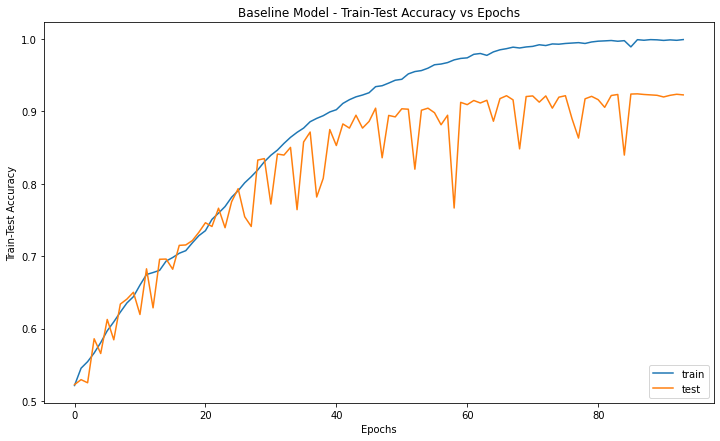

In [12]:
plt.figure(figsize=(12,7))
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Baseline Model - Train-Test Accuracy vs Epochs')
plt.ylabel('Train-Test Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='lower right')
plt.savefig(dir_name + '/train_test_acc.png')
plt.show()

Train-Val Loss vs Epochs

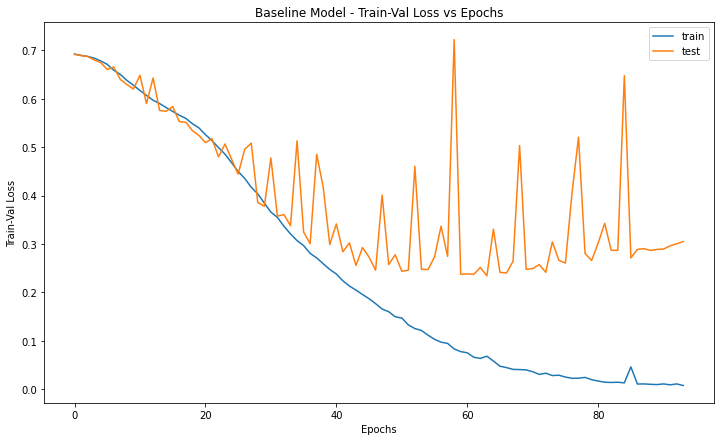

In [13]:
plt.figure(figsize=(12,7))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Baseline Model - Train-Val Loss vs Epochs')
plt.ylabel('Train-Val Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper right')
plt.savefig(dir_name + '/train_test_loss.png')
plt.show()